In [2]:
import json
from collections import defaultdict
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import utils
import plot_utils
from tqdm.notebook import tqdm, tqdm_notebook
tqdm_notebook.pandas()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
def load_public_dataset(tournament='World_Cup'):
    """
    Load the json files with the matches, events, players and competitions
    
    Parameters
    ----------
    data_folder : str, optional
        the path to the folder where json files are stored.
        
    tournaments : list, optional
        the list of tournaments to load. 
        
    Returns
    -------
    tuple
        a tuple of four dictionaries, containing matches, events, players and competitions
        
    """
    # loading the matches and events data
    matches, events = {}, {}
    with open('events/events_%s.json' %tournament) as json_data:
        events = json.load(json_data)
    with open('matches/matches_%s.json' %tournament) as json_data:
        matches = json.load(json_data)
    
    match_id2events = defaultdict(list)
    match_id2match = defaultdict(dict)
    for event in events:
        match_id = event['matchId']
        match_id2events[match_id].append(event)
                                         
    for match in matches:
        match_id = match['wyId']
        match_id2match[match_id] = match

    # loading the players data
    with open('players.json') as json_data:
        players = json.load(json_data)
    
    player_id2player = defaultdict(dict)
    for player in players:
        player_id = player['wyId']
        player_id2player[player_id] = player
    
    # loading the competitions data
    teams={}
    with open('teams.json') as json_data:
        teams = json.load(json_data)
    team_id2team = defaultdict(dict)
    for team in teams:
        team_id = team['wyId']
        team_id2team[team_id] = team

    team_id2team[3799]['name'] = 'Angers SCO'
    
    return match_id2match, match_id2events, player_id2player, team_id2team

In [4]:
def passing_networks(match_id=2057954):
    """
    Construct the passing networks of the teams in the match.
    
    Parameters
    ----------
    match_id : int, optional
        identifier of the match to plot
        
    Returns
    -------
    tuple
        the two constructed networks, as networkx objects.
    """
    
    # take the names of the two teams of the match
    match_label = match_id2match[match_id]['label']
    team1_name = match_label.split(' - ')[0].strip()
    team2_name = match_label.split(' - ')[1].split(',')[0].strip()

    # take all the events of the match
    match_events = list(match_id2events[match_id])
    match_events_df = pd.DataFrame(match_events)
    first_half_max_duration = np.max(match_events_df[match_events_df['matchPeriod'] == '1H']['eventSec'])
    # sum 1H time end to all the time in 2H
    for event in match_events:
        if event['matchPeriod'] == '2H':
            event['eventSec'] += first_half_max_duration

    team2pass2weight = defaultdict(lambda: defaultdict(int))
    for event, next_event, next_next_event in zip(match_events, match_events[1:], match_events[2:]):
        try:
            if event['eventName'] == 'Pass' and 1801 in [tag['id'] for tag in event['tags']]:
                sender = player_id2player[event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                # if the next event of from a player of the same team
                if (next_event['teamId'] == event['teamId']) & (next_event['playerId'] != event['playerId']):
                    receiver = player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                    team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                elif (next_next_event['teamId'] == event['teamId']) & (next_next_event['playerId'] != event['playerId']):
                    receiver = player_id2player[next_next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                    team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1  
        except KeyError:
            pass
    # crete networkx graphs
    G1, G2 = nx.DiGraph(team=team1_name), nx.DiGraph(team=team2_name)
    for (sender, receiver), weight in team2pass2weight[team1_name].items():
        G1.add_edge(sender, receiver, weight=weight)
    for (sender, receiver), weight in team2pass2weight[team2_name].items():
        G2.add_edge(sender, receiver, weight=weight)    
    
    return G1, G2

In [5]:
def pith_pos_to_dict(data):

    aux = data[['playerId', 'y', 'x']]
    aux['nome'] = aux['playerId'].apply(lambda p: player_id2player[p]['shortName'].encode('ascii', 'strict').decode('unicode-escape'))

    res = dict(zip(aux['nome'], zip(aux['x'], aux['y'])))

    return res

In [6]:
def plot_passing_networks(G1, G2, df_pos):
    """
    Plot the two passing networks in input.
    
    Parameters
    ----------
    G1 : networkx object
        the object representing the first network
        
    G2 : networkx object
        the object representing the second network
    """
    #TO DO:
    # ***** Plotar nodes e edges baseado no peso *****

    player_pos = pith_pos_to_dict(df_pos)

    fig, ax1 = plot_utils.pitch()
    fig, ax2 = plot_utils.pitch()
    

    nome2degree = dict(G1.degree)
    nx.draw(G1, pos=player_pos ,nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()], 
            node_color='red', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75, ax=ax1)
    ax1.set_title('Time 1')
    ax1.set_xlim([0, 100])
    ax1.set_ylim([0, 100])
    ax1.set_axis_on()

    
    nome2degree = dict(G2.degree)
    nx.draw(G2, pos=player_pos, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()],
            node_color='blue', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75, ax=ax2)
    ax2.set_title('Time 2')
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0, 100])
    ax2.set_axis_on()
    
    plt.figure(figsize=(4, 3))
    plt.show()

In [7]:
# carrega dados
match_id2match, match_id2events, player_id2player, team_id2team = load_public_dataset(tournament='France')
matches = pd.read_json('matches\matches_France.json')
events = pd.read_json('events\events_France.json')

#tira penalidades
events = events[events['matchPeriod'] != 'P']

print("map tag")
events['tags'] = events['tags'].progress_map(utils.converting_tags)

map tag


  0%|          | 0/632807 [00:00<?, ?it/s]

In [8]:
# gera coordenada média de cada node
passes = events[(events['eventName'] == 'Pass') & (events['tags'].apply(lambda x: (1801 in x)))]

coords = passes['positions'].apply(pd.Series)[0].apply(pd.Series)
passes = passes.join(coords)
passes = passes.drop(['positions'], axis = 1)

pitch_coords = passes.groupby(['matchId', 'teamId', 'playerId']).agg(y=('y','mean'), x=('x','mean'))
pitch_coords = pitch_coords.reset_index()

In [9]:
#gera redes
net_list = defaultdict(tuple)
for matchID in match_id2match.keys():    
    G1, G2 = passing_networks(match_id = matchID)
    par = (G1, G2)
    net_list[matchID] = par
    if not G1:
        print('NUUUULLL 1')
        print(G1.graph)
    if not G2:
        print('NUUUULLL 2')
        print(G2.graph)

In [104]:
matches = pd.read_json('matches\matches_France.json')

matches.tail()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
375,Played,4405655,1,"{'3783': {'scoreET': 0, 'coachId': 210513, 'si...",181189,2017-08-05 18:00:00,3787,Stade de la Mosson,2500692,"Montpellier - Caen, 1 - 0","August 5, 2017 at 8:00:00 PM GMT+2","[{'refereeId': 385496, 'role': 'referee'}, {'r...",Regular,412
376,Played,4405655,1,"{'3782': {'scoreET': 0, 'coachId': 218066, 'si...",181189,2017-08-05 18:00:00,3782,Stade Geoffroy-Guichard,2500694,"Saint-\u00c9tienne - Nice, 1 - 0","August 5, 2017 at 8:00:00 PM GMT+2","[{'refereeId': 385528, 'role': 'referee'}, {'r...",Regular,412
377,Played,4405655,1,"{'3795': {'scoreET': 0, 'coachId': 25606, 'sid...",181189,2017-08-05 18:00:00,0,Stade de l'Aube,2500695,"Troyes - Rennes, 1 - 1","August 5, 2017 at 8:00:00 PM GMT+2","[{'refereeId': 386325, 'role': 'referee'}, {'r...",Regular,412
378,Played,4405655,1,"{'3789': {'scoreET': 0, 'coachId': 26812, 'sid...",181189,2017-08-05 15:15:00,3767,Parc des Princes,2500693,"PSG - Amiens SC, 2 - 0","August 5, 2017 at 5:15:00 PM GMT+2","[{'refereeId': 381847, 'role': 'referee'}, {'r...",Regular,412
379,Played,4405655,1,"{'3780': {'scoreET': 0, 'coachId': 228969, 'si...",181189,2017-08-04 18:45:00,19830,Stade Louis II.,2500691,"Monaco - Toulouse, 3 - 2","August 4, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 384931, 'role': 'referee'}, {'r...",Regular,412


In [69]:
matches[matches['winner'] == 0]


,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
12,Played,4405517,33,"{'2443': {'scoreET': 0, 'coachId': 367510, 'si...",181137,2018-05-05 13:30:00,0,Weserstadion,2517030,"Werder Bremen - Bayer Leverkusen, 0 - 0","May 5, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 383490, 'role': 'referee'}, {'r...",Regular,426
18,Played,4405517,32,"{'2443': {'scoreET': 0, 'coachId': 367510, 'si...",181137,2018-04-29 16:00:00,0,Weserstadion,2517022,"Werder Bremen - Borussia Dortmund, 1 - 1","April 29, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 384898, 'role': 'referee'}, {'r...",Regular,426
22,Played,4405517,32,"{'2457': {'scoreET': 0, 'coachId': 17121, 'sid...",181137,2018-04-28 13:30:00,0,Olympiastadion Berlin,2517020,"Hertha BSC - Augsburg, 2 - 2","April 28, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 381840, 'role': 'referee'}, {'r...",Regular,426
24,Played,4405517,32,"{'2454': {'scoreET': 0, 'coachId': 15114, 'sid...",181137,2018-04-28 13:30:00,0,VELTINS-Arena,2517023,"Schalke 04 - Borussia M'gladbach, 1 - 1","April 28, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 385544, 'role': 'referee'}, {'r...",Regular,426
27,Played,4405517,31,"{'2449': {'scoreET': 0, 'coachId': 447924, 'si...",181137,2018-04-22 16:00:00,0,RheinEnergieStadion,2517011,"K\u00f6ln - Schalke 04, 2 - 2","April 22, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 381840, 'role': 'referee'}, {'r...",Regular,426
37,Played,4405517,30,"{'2443': {'scoreET': 0, 'coachId': 367510, 'si...",181137,2018-04-15 16:00:00,0,Weserstadion,2517003,"Werder Bremen - RB Leipzig, 1 - 1","April 15, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 383491, 'role': 'referee'}, {'r...",Regular,426
43,Played,4405517,30,"{'2455': {'scoreET': 0, 'coachId': 19925, 'sid...",181137,2018-04-14 13:30:00,0,Mercedes-Benz-Arena,2517008,"Stuttgart - Hannover 96, 1 - 1","April 14, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 387276, 'role': 'referee'}, {'r...",Regular,426
44,Played,4405517,30,"{'2451': {'scoreET': 0, 'coachId': 14735, 'sid...",181137,2018-04-13 18:30:00,0,VOLKSWAGEN ARENA,2517007,"Wolfsburg - Augsburg, 0 - 0","April 13, 2018 at 8:30:00 PM GMT+2","[{'refereeId': 379378, 'role': 'referee'}, {'r...",Regular,426
46,Played,4405517,29,"{'2482': {'scoreET': 0, 'coachId': 272299, 'si...",181137,2018-04-08 16:00:00,0,Commerzbank-Arena,2516996,"Eintracht Frankfurt - Hoffenheim, 1 - 1","April 8, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 378945, 'role': 'referee'}, {'r...",Regular,426
48,Played,4405517,29,"{'2449': {'scoreET': 0, 'coachId': 447924, 'si...",181137,2018-04-07 16:30:00,0,Volksparkstadion,2516998,"Hamburger SV - Schalke 04, 3 - 2","April 7, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 383491, 'role': 'referee'}, {'r...",Regular,426


In [68]:
team_id2team[2450]
# matches.loc[102, 'winner'] = 2449

{'city': 'Hamburg',
 'name': 'Hamburger SV',
 'wyId': 2450,
 'officialName': 'Hamburger SV',
 'area': {'name': 'Germany',
  'id': '276',
  'alpha3code': 'DEU',
  'alpha2code': 'DE'},
 'type': 'club'}

C:\Users\eduar\AppData\Local\Temp/ipykernel_16656/2647024513.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



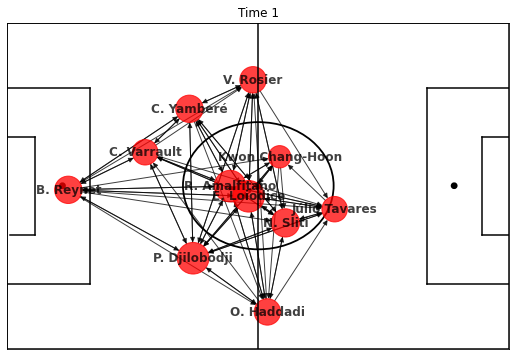

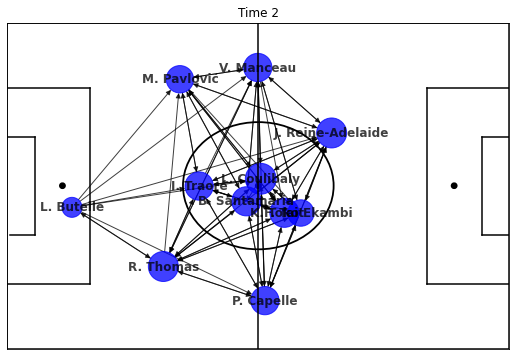

<Figure size 288x216 with 0 Axes>

In [11]:
plot_passing_networks(net_list[2501057][0], net_list[2501057][1], pitch_coords[pitch_coords['matchId'] == 2501057])

In [74]:
#degree_centrality
def degree_centrality(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append(np.mean(list(nx.degree_centrality(net[0]).values())))
        data1.append(np.mean(list(nx.degree_centrality(net[1]).values())))

    return pd.DataFrame(list(zip(data0, data1)), columns=['degree_centrality_T1', 'degree_centrality_T2'])


#betwenness_centrality
def betwenness_centrality(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append(np.mean(list(nx.betweenness_centrality(net[0]).values())))
        data1.append(np.mean(list(nx.betweenness_centrality(net[1]).values())))

    return pd.DataFrame(list(zip(data0, data1)), columns=['betweenness_centrality_T1', 'betweenness_centrality_T2'])

#closeness_centrality
def closeness_centrality(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append(np.mean(list(nx.closeness_centrality(net[0]).values())))
        data1.append(np.mean(list(nx.closeness_centrality(net[1]).values())))

    return pd.DataFrame(list(zip(data0, data1)), columns=['closeness_centrality_T1', 'closeness_centrality_T2'])

#eigenvalue_centrality
def eigenvector_centrality(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append(np.mean(list(nx.eigenvector_centrality(net[0]).values())))
        data1.append(np.mean(list(nx.eigenvector_centrality(net[1]).values())))

    return pd.DataFrame(list(zip(data0, data1)), columns=['eigenvector_centrality_T1', 'eigenvector_centrality_T2'])

#clustering coefficient
def clustering_coefficient(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append((nx.average_clustering(net[0])))
        data1.append((nx.average_clustering(net[1])))

    return pd.DataFrame(list(zip(data0, data1)), columns=['clustering_T1', 'clustering_T2'])

#average shortest path lenght
def avg_shortest_path(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append((nx.average_shortest_path_length(net[0])))
        data1.append((nx.average_shortest_path_length(net[1])))

    return pd.DataFrame(list(zip(data0, data1)), columns=['avg_shortest_path_T1', 'avg_shortest_path_T2'])

#position centroid
def centroid(netlist):
    centroid = pitch_coords.groupby(['matchId', 'teamId']).agg(y=('y','mean'), x=('x','mean')).reset_index()
    centroid = centroid.rename(columns={"y": "centroid_y", "x": "centroid_x"})
    
    return centroid



In [165]:
#degree_centrality
def degree_centrality(netlist, i):
    data_avg = []
    data_std = []
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.degree_centrality(net[i]).values())))
        data_std.append(np.std(list(nx.degree_centrality(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_degree_centrality_T{i+1}', f'std_degree_centrality_T{i+1}'])


#betwenness_centrality
def betwenness_centrality(netlist, i):
    data_avg = []
    data_std = []
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.betweenness_centrality(net[i]).values())))
        data_std.append(np.std(list(nx.betweenness_centrality(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_betweenness_centrality_T{i+1}', f'std_betweenness_centrality_T{i+1}'])

#closeness_centrality
def closeness_centrality(netlist, i):
    data_avg = []
    data_std = [] 
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.closeness_centrality(net[i]).values())))
        data_std.append(np.std(list(nx.closeness_centrality(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_closeness_centrality_T{i+1}', f'std_closeness_centrality_T{i+1}'])

#eigenvalue_centrality
def eigenvector_centrality(netlist, i):
    data_avg = []
    data_std = []
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.eigenvector_centrality(net[i]).values())))
        data_std.append(np.std(list(nx.eigenvector_centrality(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_eigenvector_centrality_T{i+1}', f'std_eigenvector_centrality_T{i+1}'])

#clustering coefficient
def clustering_coefficient(netlist, i):
    data_avg = []
    data_std = []
    for net in netlist.values():
        data_avg.append(np.mean(list(nx.clustering(net[i]).values())))
        data_std.append(np.std(list(nx.clustering(net[i]).values())))

    return pd.DataFrame(list(zip(data_avg, data_std)), columns=[f'avg_clustering_T{i+1}', f'std_clustering_T{i+1}'])

#average shortest path lenght
def avg_shortest_path(netlist, i):
    data_avg = []
    for net in netlist.values():
        data_avg.append((nx.average_shortest_path_length(net[i])))

    return pd.DataFrame(data_avg, columns=[f'avg_shortest_path_T{i+1}'])

#position centroid
def centroid(netlist, i):
    centroid = pitch_coords.groupby(['matchId', 'teamId']).agg({'y':([np.mean, np.std]), 'x':([np.mean, np.std])}).reset_index()
    centroid.columns = ['matchId', 'teamId', f'mean_centroid_y_T{i+1}', f'std_centroid_y_T{i+1}', f'mean_centroid_x_T{i+1}', f'std_centroid_x_T{i+1}']
    
    return centroid

In [162]:
# -- HOME --

dfh = matches[['wyId']]
dfh = dfh.rename(columns={'wyId':'matchID'})

home_l = []
away_l = []

for match in matches['teamsData']:
    t0 = list(match.values())[0]
    t1 = list(match.values())[1]

    if t0['side'] == 'home':
        home_l.append(t0['teamId'])
        away_l.append(t1['teamId'])  
    else: 
        away_l.append(t0['teamId'])
        home_l.append(t1['teamId'])

dfh['team1_ID'] = home_l
dfh['team2_ID'] = away_l

dfh['date'] = matches['date']

dfh['tournament'] = 'Germany'

closeness = closeness_centrality(net_list, 0)
degree = degree_centrality(net_list, 0)
betwenness = betwenness_centrality(net_list, 0)
eigenvector = eigenvector_centrality(net_list, 0)
clustering = clustering_coefficient(net_list, 0)
shortest_path = avg_shortest_path(net_list, 0)
df_centroid = centroid(net_list, 0)

dfh = dfh.join(closeness)
dfh = dfh.join(degree)
dfh = dfh.join(betwenness)
dfh = dfh.join(eigenvector)
dfh = dfh.join(clustering)
dfh = dfh.join(shortest_path)

dfh = dfh.merge(df_centroid, how='left', left_on=['matchID', 'team1_ID'], right_on=['matchId', 'teamId']).drop(['matchId', 'teamId'], axis=1)

dfh.head(10)

,matchID,team1_ID,team2_ID,date,tournament,avg_closeness_centrality_T1,std_closeness_centrality_T1,avg_degree_centrality_T1,std_degree_centrality_T1,avg_betweenness_centrality_T1,std_betweenness_centrality_T1,avg_eigenvector_centrality_T1,std_eigenvector_centrality_T1,avg_clustering_T1,std_clustering_T1,avg_shortest_path_T1,mean_centroid_y_T1,std_centroid_y_T1,mean_centroid_xT1,std_centroid_x_T1
0,2501058,3766,3775,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.842096,0.103652,1.581818,0.300963,0.023232,0.014181,0.293852,0.067529,0.831397,0.060187,1.209091,47.258515,20.576433,54.354605,16.685909
1,2501059,3771,3789,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.907396,0.100615,1.763636,0.205704,0.013131,0.006574,0.298113,0.045143,0.896982,0.031428,1.118182,55.022492,19.492313,48.478250,16.450237
2,2501060,3777,3772,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.784045,0.084689,1.418182,0.321412,0.032323,0.022406,0.296557,0.054432,0.766908,0.064110,1.290909,47.537218,26.091527,45.234827,15.833159
3,2501061,3770,3779,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.850997,0.098120,1.618182,0.189824,0.021212,0.012475,0.297392,0.049671,0.820957,0.033697,1.190909,50.684403,20.322948,44.729041,16.464676
4,2501063,3782,3776,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.873475,0.079327,1.690909,0.219315,0.017172,0.008611,0.299520,0.034597,0.868299,0.036406,1.154545,52.596495,19.710435,43.970982,17.347578
5,2501064,3780,3785,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.819635,0.094110,1.527273,0.195824,0.026263,0.010734,0.296303,0.055802,0.772217,0.019499,1.236364,50.668485,21.731264,46.641473,16.370875
6,2501065,3795,19830,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.836705,0.135182,1.545455,0.197086,0.025253,0.014139,0.291859,0.075678,0.785305,0.036659,1.227273,51.759585,20.864095,48.913669,16.323389
7,2501046,3789,3777,"May 12, 2018 at 9:00:00 PM GMT+2",Germany,0.840444,0.123369,1.563636,0.302333,0.024242,0.016146,0.293875,0.067430,0.838560,0.056112,1.218182,49.473081,19.804286,41.956999,13.921480
8,2501048,3772,3780,"May 12, 2018 at 9:00:00 PM GMT+2",Germany,0.844533,0.114334,1.581818,0.251606,0.023232,0.018464,0.294160,0.066173,0.823678,0.050978,1.209091,55.346334,21.657995,47.031685,15.851365
9,2501050,3776,3804,"May 12, 2018 at 9:00:00 PM GMT+2",Germany,0.844232,0.093170,1.600000,0.200000,0.022222,0.009116,0.297776,0.047313,0.809458,0.040631,1.200000,54.181854,21.188450,47.172351,15.789917


In [166]:
# -- AWAY --

dfa = matches[['wyId']]
dfa = dfa.rename(columns={'wyId':'matchID'})

home_l = []
away_l = []

for match in matches['teamsData']:
    t0 = list(match.values())[0]
    t1 = list(match.values())[1]

    if t0['side'] == 'home':
        home_l.append(t0['teamId'])
        away_l.append(t1['teamId'])  
    else: 
        away_l.append(t0['teamId'])
        home_l.append(t1['teamId'])

dfa['team1_ID'] = home_l
dfa['team2_ID'] = away_l

dfa['date'] = matches['date']

dfa['tournament'] = 'Germany'

closeness = closeness_centrality(net_list, 1)
degree = degree_centrality(net_list, 1)
betwenness = betwenness_centrality(net_list, 1)
eigenvector = eigenvector_centrality(net_list, 1)
clustering = clustering_coefficient(net_list, 1)
shortest_path = avg_shortest_path(net_list, 1)
df_centroid = centroid(net_list, 1)

dfa = dfa.join(closeness)
dfa = dfa.join(degree)
dfa = dfa.join(betwenness)
dfa = dfa.join(eigenvector)
dfa = dfa.join(clustering)
dfa = dfa.join(shortest_path)

dfa = dfa.merge(df_centroid, how='left', left_on=['matchID', 'team2_ID'], right_on=['matchId', 'teamId']).drop(['matchId', 'teamId'], axis=1)

dfa.head(10)

,matchID,team1_ID,team2_ID,date,tournament,avg_closeness_centrality_T2,std_closeness_centrality_T2,avg_degree_centrality_T2,std_degree_centrality_T2,avg_betweenness_centrality_T2,std_betweenness_centrality_T2,avg_eigenvector_centrality_T2,std_eigenvector_centrality_T2,avg_clustering_T2,std_clustering_T2,avg_shortest_path_T2,mean_centroid_y_T2,std_centroid_y_T2,mean_centroid_x_T2,std_centroid_x_T2
0,2501058,3766,3775,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.852644,0.100202,1.618182,0.262222,0.021212,0.011358,0.296445,0.055039,0.843517,0.041423,1.190909,47.669013,20.139666,42.186351,14.843456
1,2501059,3771,3789,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.829382,0.103231,1.545455,0.227091,0.025253,0.015943,0.293815,0.067688,0.790433,0.039238,1.227273,46.355700,19.267968,38.718618,13.959132
2,2501060,3777,3772,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.840962,0.076308,1.600000,0.273030,0.022222,0.011656,0.298331,0.043680,0.835168,0.035300,1.200000,51.532777,23.830305,45.338007,15.906882
3,2501061,3770,3779,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.892001,0.114451,1.709091,0.235312,0.016162,0.012364,0.295036,0.062151,0.876078,0.041454,1.145455,50.064026,23.181571,44.177381,12.550558
4,2501063,3782,3776,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.849768,0.113352,1.600000,0.273030,0.022222,0.011053,0.294924,0.062681,0.834531,0.051048,1.200000,53.150275,21.480358,48.271778,16.220278
5,2501064,3780,3785,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.808642,0.117463,1.472727,0.213588,0.029293,0.017782,0.292565,0.072903,0.744825,0.040508,1.263636,50.530438,23.581552,47.921760,15.544899
6,2501065,3795,19830,"May 19, 2018 at 9:00:00 PM GMT+2",Germany,0.785997,0.111504,1.400000,0.330289,0.033333,0.031467,0.291738,0.076146,0.780952,0.066293,1.300000,52.999746,23.190151,48.713319,17.090101
7,2501046,3789,3777,"May 12, 2018 at 9:00:00 PM GMT+2",Germany,0.861968,0.111768,1.636364,0.166639,0.020202,0.010280,0.295445,0.060177,0.820064,0.023764,1.181818,50.007045,21.690795,50.352526,15.729629
8,2501048,3772,3780,"May 12, 2018 at 9:00:00 PM GMT+2",Germany,0.793373,0.039489,1.472727,0.213588,0.029293,0.014616,0.300387,0.026018,0.742081,0.037605,1.263636,52.002186,21.801487,45.357465,16.049865
9,2501050,3776,3804,"May 12, 2018 at 9:00:00 PM GMT+2",Germany,0.887079,0.100665,1.709091,0.206506,0.016162,0.010424,0.296290,0.055869,0.867390,0.024310,1.145455,48.354043,17.751559,50.834231,15.145271


In [110]:
df = matches[['wyId']]
df = df.rename(columns={'wyId':'matchID'})

home_l = []
away_l = []

for match in matches['teamsData']:
    t0 = list(match.values())[0]
    t1 = list(match.values())[1]

    if t0['side'] == 'home':
        home_l.append(t0['teamId'])
        away_l.append(t1['teamId'])  
    else: 
        away_l.append(t0['teamId'])
        home_l.append(t1['teamId'])

df['team1_ID'] = home_l
df['team2_ID'] = away_l

df['tournament'] = 'Germany'

closeness = closeness_centrality(net_list)
degree = degree_centrality(net_list)
betwenness = betwenness_centrality(net_list)
eigenvector = eigenvector_centrality(net_list)
clustering = clustering_coefficient(net_list)
shortest_path = avg_shortest_path(net_list)
df_centroid = centroid(net_list)

df = df.join(closeness)
df = df.join(degree)
df = df.join(betwenness)
df = df.join(eigenvector)
df = df.join(clustering)
df = df.join(shortest_path)

df = df.merge(df_centroid, how='left', left_on=['matchID', 'team1_ID'], right_on=['matchId', 'teamId']).drop(['matchId', 'teamId'], axis=1)
df = df.merge(df_centroid, how='left', left_on=['matchID', 'team2_ID'], right_on=['matchId', 'teamId']).drop(['matchId', 'teamId'], axis=1)
df = df.rename(columns={"centroid_y_x": "centroid_y_T1", "centroid_x_x": "centroid_x_T1"})
df = df.rename(columns={"centroid_y_y": "centroid_y_T2", "centroid_x_y": "centroid_x_T2"})


# df['winner'] = np.where((matches['winner'] == df['team1_ID']), 1, 0)

df

,matchID,team1_ID,team2_ID,tournament,closeness_centrality_T1,closeness_centrality_T2,degree_centrality_T1,degree_centrality_T2,betweenness_centrality_T1,betweenness_centrality_T2,eigenvector_centrality_T1,eigenvector_centrality_T2,clustering_T1,clustering_T2,avg_shortest_path_T1,avg_shortest_path_T2,centroid_y_T1,centroid_x_T1,centroid_y_T2,centroid_x_T2
0,2501058,3766,3775,Germany,0.842096,0.852644,1.581818,1.618182,0.023232,0.021212,0.293852,0.296445,0.831397,0.843517,1.209091,1.190909,47.258515,54.354605,47.669013,42.186351
1,2501059,3771,3789,Germany,0.907396,0.829382,1.763636,1.545455,0.013131,0.025253,0.298113,0.293815,0.896982,0.790433,1.118182,1.227273,55.022492,48.478250,46.355700,38.718618
2,2501060,3777,3772,Germany,0.784045,0.840962,1.418182,1.600000,0.032323,0.022222,0.296557,0.298331,0.766908,0.835168,1.290909,1.200000,47.537218,45.234827,51.532777,45.338007
3,2501061,3770,3779,Germany,0.850997,0.892001,1.618182,1.709091,0.021212,0.016162,0.297392,0.295036,0.820957,0.876078,1.190909,1.145455,50.684403,44.729041,50.064026,44.177381
4,2501063,3782,3776,Germany,0.873475,0.849768,1.690909,1.600000,0.017172,0.022222,0.299520,0.294924,0.868299,0.834531,1.154545,1.200000,52.596495,43.970982,53.150275,48.271778
5,2501064,3780,3785,Germany,0.819635,0.808642,1.527273,1.472727,0.026263,0.029293,0.296303,0.292565,0.772217,0.744825,1.236364,1.263636,50.668485,46.641473,50.530438,47.921760
6,2501065,3795,19830,Germany,0.836705,0.785997,1.545455,1.400000,0.025253,0.033333,0.291859,0.291738,0.785305,0.780952,1.227273,1.300000,51.759585,48.913669,52.999746,48.713319
7,2501046,3789,3777,Germany,0.840444,0.861968,1.563636,1.636364,0.024242,0.020202,0.293875,0.295445,0.838560,0.820064,1.218182,1.181818,49.473081,41.956999,50.007045,50.352526
8,2501048,3772,3780,Germany,0.844533,0.793373,1.581818,1.472727,0.023232,0.029293,0.294160,0.300387,0.823678,0.742081,1.209091,1.263636,55.346334,47.031685,52.002186,45.357465
9,2501050,3776,3804,Germany,0.844232,0.887079,1.600000,1.709091,0.022222,0.016162,0.297776,0.296290,0.809458,0.867390,1.200000,1.145455,54.181854,47.172351,48.354043,50.834231


In [111]:
df.shape

(282, 20)

In [107]:
df['winner'] = matches['winner']
df = df.loc[df['winner'] != 0]
matches = matches.loc[matches['winner'] != 0]
df['winner'] = np.where((matches['winner'] == df['team1_ID']), 1, 0)

C:\Users\eduar\AppData\Local\Temp/ipykernel_21588/3585198447.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
df

,matchID,team1_ID,team2_ID,tournament,closeness_centrality_T1,closeness_centrality_T2,degree_centrality_T1,degree_centrality_T2,betweenness_centrality_T1,betweenness_centrality_T2,eigenvector_centrality_T1,eigenvector_centrality_T2,clustering_T1,clustering_T2,avg_shortest_path_T1,avg_shortest_path_T2,centroid_y_T1,centroid_x_T1,centroid_y_T2,centroid_x_T2,winner
2,2501058,3766,3775,Germany,0.842096,0.852644,1.581818,1.618182,0.023232,0.021212,0.293852,0.296445,0.831397,0.843517,1.209091,1.190909,47.258515,54.354605,47.669013,42.186351,1
3,2501059,3771,3789,Germany,0.907396,0.829382,1.763636,1.545455,0.013131,0.025253,0.298113,0.293815,0.896982,0.790433,1.118182,1.227273,55.022492,48.478250,46.355700,38.718618,1
4,2501060,3777,3772,Germany,0.784045,0.840962,1.418182,1.600000,0.032323,0.022222,0.296557,0.298331,0.766908,0.835168,1.290909,1.200000,47.537218,45.234827,51.532777,45.338007,0
5,2501061,3770,3779,Germany,0.850997,0.892001,1.618182,1.709091,0.021212,0.016162,0.297392,0.295036,0.820957,0.876078,1.190909,1.145455,50.684403,44.729041,50.064026,44.177381,1
7,2501063,3782,3776,Germany,0.873475,0.849768,1.690909,1.600000,0.017172,0.022222,0.299520,0.294924,0.868299,0.834531,1.154545,1.200000,52.596495,43.970982,53.150275,48.271778,1
8,2501064,3780,3785,Germany,0.819635,0.808642,1.527273,1.472727,0.026263,0.029293,0.296303,0.292565,0.772217,0.744825,1.236364,1.263636,50.668485,46.641473,50.530438,47.921760,1
9,2501065,3795,19830,Germany,0.836705,0.785997,1.545455,1.400000,0.025253,0.033333,0.291859,0.291738,0.785305,0.780952,1.227273,1.300000,51.759585,48.913669,52.999746,48.713319,0
10,2501046,3789,3777,Germany,0.840444,0.861968,1.563636,1.636364,0.024242,0.020202,0.293875,0.295445,0.838560,0.820064,1.218182,1.181818,49.473081,41.956999,50.007045,50.352526,1
12,2501048,3772,3780,Germany,0.844533,0.793373,1.581818,1.472727,0.023232,0.029293,0.294160,0.300387,0.823678,0.742081,1.209091,1.263636,55.346334,47.031685,52.002186,45.357465,1
13,2501050,3776,3804,Germany,0.844232,0.887079,1.600000,1.709091,0.022222,0.016162,0.297776,0.296290,0.809458,0.867390,1.200000,1.145455,54.181854,47.172351,48.354043,50.834231,1
